### Support Vector Machines

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Machine Learning in Python: a Hands-on Guide with Code". 

Cite as: Pyrcz, M.J., 2024, Applied Machine Learning in Python: a Hands-on Guide with Code, https://geostatsguy.github.io/MachineLearningDemos_Book. 

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **Support Vector Machines**. 

**YouTube Lecture**: check out my lectures on:

* [Introduction to Machine Learning](https://youtu.be/zOUM_AnI1DQ?si=wzWdJ35qJ9n8O6Bl)
* [Polynomial Regression](https://youtu.be/z19Hs2HfO88?si=U2eAMJcMXRMwHG0C)
* [Support Vector Machines](https://youtu.be/UpN6TLMJiGg?si=-aevKAWNqk_sXxYO)

These lectures are all part of my [Machine Learning Course](https://youtube.com/playlist?list=PLG19vXLQHvSC2ZKFIkgVpI9fCjkN38kwf&si=XonjO2wHdXffMpeI) on YouTube with linked well-documented Python workflows and interactive dashboards. My goal is to share accessible, actionable, and repeatable educational content. If you want to know about my motivation, check out [Michael's Story](https://michaelpyrcz.com/my-story). 

#### Motivations for Support Vector Machines

Support vector machines are a predictive machine learning method for supervised learning for classification and regression analysis. It is important to know about support vector machines,

* good classification method when there is poor separation of groups
* projects the original predictor features to higher dimensional space and then applies a linear (plane/hyperplane) classification boundary

Here are some key aspects of support vector machines,

**Prediction**

* estimate a function $\hat{f}$ such that we predict a response feature $Y$ from a set of predictor features $X_1,\ldots,X_m$. 

* the prediction is of the form $\hat{Y} = \hat{f}(X_1,\ldots,X_m)$ 

**Supervised learning**

* the response feature label, $Y$, is available over the training and testing data

**Unsupervised learning**

* is available with **support vector clustering** 
    
**Binary separator**

* given the data within a mD feature space, $X_1,\ldots,X_m$, find that boundary maximizes the gap between the two categories

* new cases are classified based on where they fall relative to this boundary 

**Linear and Non-linear**

* **maximum margin classifier**, assignment of a m-1 dimensional hyperplane that maximizes the gap (margin) between the two categories

* **mapped to a higher dimensional space** based on a kernel function, e.g. polygonal and Gaussian radial basis function shown below 

#### Load the Required Libraries

We will also need some standard packages. These should have been installed with Anaconda 3.

In [3]:
%matplotlib inline                                         
suppress_warnings = True
import os                                                     # to set current working directory 
import math                                                   # square root operator
import numpy as np                                            # arrays and matrix math
import scipy.stats as st                                      # statistical methods
import pandas as pd                                           # DataFrames
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator,AutoMinorLocator,FuncFormatter,NullLocator) # control of axes ticks
from matplotlib.colors import ListedColormap                  # custom color maps
import seaborn as sns                                         # for matrix scatter plots
from sklearn.svm import SVC                                   # support vector machine methods
from sklearn import metrics                                   # measures to check our models
from sklearn.metrics import confusion_matrix                  # for summarizing model performance
from sklearn.preprocessing import StandardScaler              # standardize the features
from sklearn.model_selection import (cross_val_score,train_test_split,GridSearchCV,StratifiedShuffleSplit) # model tuning
from sklearn.pipeline import (Pipeline,make_pipeline)         # machine learning modeling pipeline
from sklearn import metrics                                   # measures to check our models
from sklearn.model_selection import cross_val_score           # multi-processor K-fold crossvalidation
from sklearn.model_selection import train_test_split          # train and test split
from IPython.display import display, HTML                     # custom displays
cmap = plt.cm.inferno                                         # default color bar, no bias
binary_cmap = ListedColormap(['grey', 'gold'])                # custom binary categorical colormap
plt.rc('axes', axisbelow=True)                                # grid behind plotting elements
if suppress_warnings == True:  
    import warnings                                           # suppress any warnings for this demonstration
    warnings.filterwarnings('ignore') 
seed = 13                                                     # random number seed for workflow repeatability

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare Functions

Let's define a couple of functions to streamline plotting correlation matrices and visualization of a decision tree regression model. 

In [5]:
def comma_format(x, pos):
    return f'{int(x):,}'

def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks  

def plot_CDF(data,color,alpha=1.0,lw=1,ls='solid',label='none'):
    cumprob = (np.linspace(1,len(data),len(data)))/(len(data)+1)
    plt.scatter(np.sort(data),cumprob,c=color,alpha=alpha,edgecolor='black',lw=lw,ls=ls,label=label,zorder=10)
    plt.plot(np.sort(data),cumprob,c=color,alpha=alpha,lw=lw,ls=ls,zorder=8)

def visualize_SVM(model,xfeature,x_min,x_max,yfeature,y_min,y_max,response,z_min,z_max,xlabel,ylabel,title,cat,label,cmap,plot_support): 
    xplot_step = (x_max - x_min)/300.0; yplot_step = (y_max - y_min)/300.0 # resolution of the model visualization
    xx, yy = np.meshgrid(np.arange(x_min, x_max, xplot_step), # set up the mesh
                     np.arange(y_min, y_max, yplot_step))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])          # predict with our trained model over the mesh
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy,Z,cmap=cmap,vmin=z_min,vmax=z_max,levels = 50,alpha=0.6) # plot the predictions
    for i in range(len(cat)):
        im = plt.scatter(xfeature[response==cat[i]],yfeature[response==cat[i]],s=None,c=response[response==cat[i]], 
                    marker=None, cmap=cmap, norm=None,vmin=z_min,vmax=z_max,alpha=0.8,linewidths=0.3, edgecolors="black")
    plt.scatter(-9999,-9999,marker='s',c = cat[0],label=label[0],cmap=cmap,vmin=z_min,vmax=z_max) # custom legend
    plt.scatter(-9999,-9999,marker='s',c = cat[1],label=label[1],cmap=cmap,vmin=z_min,vmax=z_max)
    plt.scatter(-999,-999,s=80,marker='o',color = 'white',alpha = 0.8,edgecolor = 'black',zorder=1,label='Train')
    if plot_support:                                          # modified from Jake VanderPlas's Python Data Science Handbook 
        sv = model.support_vectors_                           # retrieve the support vectors
        plt.scatter(sv[:, 0],sv[:, 1],s=3,linewidth=8,alpha = 0.6,facecolors='black',label='Support Vector');
    plt.legend(loc='upper right'); plt.title(title)                    
    plt.xlabel(xlabel); plt.ylabel(ylabel)
    plt.xlim([x_min,x_max]); plt.ylim([y_min,y_max]); add_grid()

def display_sidebyside(*args):                                # display DataFrames side-by-side (ChatGPT 4.0 generated Spet, 2024)
    html_str = ''
    for df in args:
        html_str += df.head().to_html()                       # Using .head() for the first few rows
    display(HTML(f'<div style="display: flex;">{html_str}</div>'))

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).

In [7]:
#os.chdir("c:/PGE383")                                        # set the working directory

#### Loading Data
Let's load the provided multivariate, spatial dataset '12_sample_data.csv'.  It is a comma delimited file with: 

* X and Y coordinates ($m$)
* facies 0 and 1 
* porosity (fraction)
* permeability ($mD$)
* acoustic impedance ($\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$). 

We load it with the pandas 'read_csv' function into a data frame we called 'df' and then preview it to make sure it loaded correctly.

**Python Tip: using functions from a package** just type the label for the package that we declared at the beginning:

```python
import pandas as pd
```

so we can access the pandas function 'read_csv' with the command: 

```python
pd.read_csv()
```

but read csv has required input parameters. The essential one is the name of the file. For our circumstance all the other default parameters are fine. If you want to see all the possible parameters for this function, just go to the docs [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html).  

* The docs are always helpful
* There is often a lot of flexibility for Python functions, possible through using various inputs parameters

also, the program has an output, a pandas DataFrame loaded from the data.  So we have to specficy the name / variable representing that new object.

```python
df = pd.read_csv("12_sample_data.csv")  
```

#### Standardize Predictor Features

The support vector machines minimize the error, the distance of training data from the margin. Therefore, this method is sensitivity to the relative ranges of the predictor features. 

* if one predictor feature has a much larger range then it will dominate the model, the model will only separate on that feature! The result is a model orthogonal to that one feature, i.e., splitting only on that feature.

In [9]:
df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/12_sample_data.csv")

yname = 'Facies'; Xname = ['Porosity','AI']                   # specify the predictor features (x2) and response feature (x1)
Xmin = [0.1,1500.0]; Xmax = [0.3,6500.0]                      # set minimums and maximums for visualization 
ymin = 0.0; ymax = 1.0
Xlabel = ['Porosity','Acoustic Impedance']; ylabel = 'Facies' # specify the feature labels for plotting
Xunit = ['Fraction',r'$\frac{kg}{m^3} \cdot \frac{m}{s} \cdot 10^3$']; yunit = 'MCFPD'
Xlabelunit = [Xlabel[0] + ' (' + Xunit[0] + ')',Xlabel[1] + ' (' + Xunit[1] + ')']
ylabelunit = ylabel + ' (' + yunit + ')'

y = pd.DataFrame(df[yname])                                   # extract selected features as X and y DataFrames
X = df[Xname]

ysname = 's' + yname; Xsname = ['s' + element for element in Xname] # standardized predictor names
Xsmin = [-3.0,-3.0]; Xsmax = [3.0,3.0]                        # set minimums and maximums for standardized features
Xslabel = ['Standardized ' + element for element in Xlabel]   # standardized predictor names
Xsunit = ['S[' + element + ']' for element in Xunit]          # standardized predictor names
Xslabelunit = [Xslabel[0] + ' (' + Xsunit[0] + ')',Xslabel[1] + ' (' + Xsunit[1] + ')']

transform = StandardScaler();                                 # instantiate feature standardization method
Xs = transform.fit_transform(X)                               # standardize the data features to mean = 0, var = 1.0
X[Xsname] = Xs                                                # add standardized features to the predictor feature DataFrame

#### Train and Test Split

For convenience and simplicity we use scikit-learn's random train and test split.

* we use the same random_state parameter so the train and test splits on original and standardized features are the same.
* I could have just backtransformed the standardize latter (spoiler alert, I'm going to show the impact of not standardizing on the model).
* typically we don't have to back transform the predictor features, for our prediction workflows it is a one way trip for the predictor features.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=73073) # train and test split
df_train = pd.concat([X_train,y_train],axis=1)                # make one train and test DataFrame with both X and y
df_test = pd.concat([X_test,y_test],axis=1)                   

#### Visualize the DataFrame

Visualizing the train and test DataFrame is useful check before we build our models.

* many things can go wrong, e.g., we loaded the wrong data, all the features did not load, etc.

We can preview by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). 

In [13]:
print('       Training DataFrame          Testing DataFrame')
display_sidebyside(df_train,df_test)                          # custom function for side-by-side DataFrame display

       Training DataFrame          Testing DataFrame


#### Summary Statistics for Tabular Data

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. 

* The describe command provides count, mean, minimum, maximum in a nice data table. 

In [15]:
print('            Training DataFrame                      Testing DataFrame') # custom function for side-by-side summary statistics
display_sidebyside(df_train.describe().loc[['count', 'mean', 'std', 'min', 'max']],df_test.describe().loc[['count', 'mean', 'std', 'min', 'max']])

            Training DataFrame                      Testing DataFrame


It is good that we checked the summary statistics.

* there are no obvious issues
* check out the range of values for each feature to set up and adjust plotting limits. See above.

#### Visualize the Train and Test Splits

Let's check the consistency and coverage of training and testing with histograms and scatter plots.

* check to make sure the training and testing cover the range of possible feature combinations
* ensure we are not extrapolating beyond the training data with the testing cases

In [17]:
nbins = 20                                                    # number of histogram bins

plt.subplot(231)                                              # predictor feature #1 histogram
freq1,_,_ = plt.hist(x=X_train[Xname[0]],weights=None,bins=np.linspace(Xmin[0],Xmax[0],nbins),alpha = 0.6,
                     edgecolor='black',color='darkorange',density=False,label='Train')
freq2,_,_ = plt.hist(x=X_test[Xname[0]],weights=None,bins=np.linspace(Xmin[0],Xmax[0],nbins),alpha = 0.6,
                     edgecolor='black',color='red',density=False,label='Test')
max_freq = max(freq1.max()*1.10,freq2.max()*1.10)
plt.xlabel(Xlabelunit[0]); plt.ylabel('Frequency'); plt.ylim([0.0,max_freq]); plt.title(Xlabel[0]); add_grid()  
plt.xlim([Xmin[0],Xmax[0]]); plt.legend(loc='upper right')   

plt.subplot(232)                                              # predictor feature #2 histogram
freq1,_,_ = plt.hist(x=X_train[Xname[1]],weights=None,bins=np.linspace(Xmin[1],Xmax[1],nbins),alpha = 0.6,
                     edgecolor='black',color='darkorange',density=False,label='Train')
freq2,_,_ = plt.hist(x=X_test[Xname[1]],weights=None,bins=np.linspace(Xmin[1],Xmax[1],nbins),alpha = 0.6,
                     edgecolor='black',color='red',density=False,label='Test')
max_freq = max(freq1.max()*1.10,freq2.max()*1.10)
plt.xlabel(Xlabelunit[1]); plt.ylabel('Frequency'); plt.ylim([0.0,max_freq]); plt.title(Xlabel[1]); add_grid()  
plt.gca().xaxis.set_major_formatter(FuncFormatter(comma_format))
plt.xlim([Xmin[1],Xmax[1]]); plt.legend(loc='upper right')   

plt.subplot(233)                                              # predictor features #1 and #2 scatter plot
plt.scatter(X_train[Xname[0]],X_train[Xname[1]],s=40,marker='o',color = 'darkorange',alpha = 0.8,edgecolor = 'black',zorder=10,label='Train')
plt.scatter(X_test[Xname[0]],X_test[Xname[1]],s=40,marker='o',color = 'red',alpha = 0.8,edgecolor = 'black',zorder=10,label='Test')
plt.title(Xlabel[0] + ' vs ' +  Xlabel[1])
plt.xlabel(Xlabelunit[0]); plt.ylabel(Xlabelunit[1])
plt.legend(); add_grid(); plt.xlim([Xmin[0],Xmax[0]]); plt.ylim([Xmin[1],Xmax[1]])
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.subplot(234)                                              # predictor feature #1 histogram
freq1,_,_ = plt.hist(x=X_train[Xsname[0]],weights=None,bins=np.linspace(Xsmin[0],Xsmax[0],nbins),alpha = 0.6,
                     edgecolor='black',color='darkorange',density=False,label='Train')
freq2,_,_ = plt.hist(x=X_test[Xsname[0]],weights=None,bins=np.linspace(Xsmin[0],Xsmax[0],nbins),alpha = 0.6,
                     edgecolor='black',color='red',density=False,label='Test')
max_freq = max(freq1.max()*1.10,freq2.max()*1.10)
plt.xlabel(Xslabelunit[0]); plt.ylabel('Frequency'); plt.ylim([0.0,max_freq]); plt.title(Xslabel[0]); add_grid()  
plt.xlim([Xsmin[0],Xsmax[0]]); plt.legend(loc='upper right')   

plt.subplot(235)                                              # predictor feature #2 histogram
freq1,_,_ = plt.hist(x=X_train[Xsname[1]],weights=None,bins=np.linspace(Xsmin[1],Xsmax[1],nbins),alpha = 0.6,
                     edgecolor='black',color='darkorange',density=False,label='Train')
freq2,_,_ = plt.hist(x=X_test[Xsname[1]],weights=None,bins=np.linspace(Xsmin[1],Xsmax[1],nbins),alpha = 0.6,
                     edgecolor='black',color='red',density=False,label='Test')
max_freq = max(freq1.max()*1.10,freq2.max()*1.10)
plt.xlabel(Xslabelunit[1]); plt.ylabel('Frequency'); plt.ylim([0.0,max_freq]); plt.title(Xslabel[1]); add_grid()  
plt.xlim([Xsmin[1],Xsmax[1]]); plt.legend(loc='upper right')   

plt.subplot(236)                                              # predictor features #1 and #2 scatter plot
plt.scatter(X_train[Xsname[0]],X_train[Xsname[1]],s=40,marker='o',color = 'darkorange',alpha = 0.8,edgecolor = 'black',zorder=10,label='Train')
plt.scatter(X_test[Xsname[0]],X_test[Xsname[1]],s=40,marker='o',color = 'red',alpha = 0.8,edgecolor = 'black',zorder=10,label='Test')
plt.title(Xslabel[0] + ' vs ' +  Xslabel[1])
plt.xlabel(Xslabelunit[0]); plt.ylabel(Xslabelunit[1])
plt.legend(); add_grid(); plt.xlim([Xsmin[0],Xsmax[0]]); plt.ylim([Xsmin[1],Xsmax[1]])

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1.6, wspace=0.3, hspace=0.25)
#plt.savefig('Test.pdf', dpi=600, bbox_inches = 'tight',format='pdf')   
plt.show()

Sometimes I find it more convenient to compare distributions by looking at CDF's instead of histograms.
* we avoid the arbitrary choice of histogram bin size, because CDF's are at the data resolution.

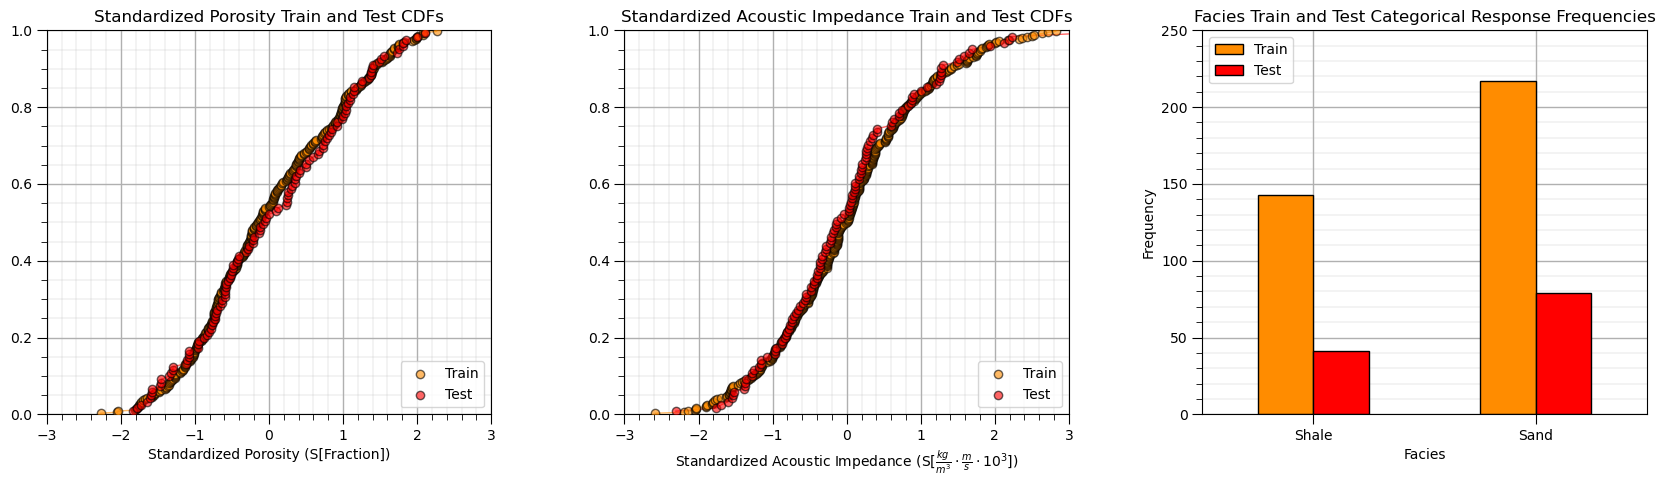

In [19]:
plt.subplot(131)                                              # predictor feature #1 CDF
plot_CDF(X_train[Xsname[0]],'darkorange',alpha=0.6,lw=1,ls='solid',label='Train')
plot_CDF(X_test[Xsname[0]],'red',alpha=0.6,lw=1,ls='solid',label='Test')
plt.xlabel(Xslabelunit[0]); plt.xlim(Xsmin[0],Xsmax[0]); plt.ylim([0,1]); add_grid(); plt.legend(loc='lower right')
plt.title(Xslabel[0] + ' Train and Test CDFs')

plt.subplot(132)                                              # predictor feature #2 CDF
plot_CDF(X_train[Xsname[1]],'darkorange',alpha=0.6,lw=1,ls='solid',label='Train')
plot_CDF(X_test[Xsname[1]],'red',alpha=0.6,lw=1,ls='solid',label='Test')
plt.xlabel(Xslabelunit[1]); plt.xlim(Xsmin[1],Xsmax[1]); plt.ylim([0,1]); add_grid(); plt.legend(loc='lower right')
plt.title(Xslabel[1] + ' Train and Test CDFs')

plt.subplot(133)                                              # categorical response feature grouped histogram
plt.bar([-0.125],len(y_train[yname][y_train[yname]==0]),width=0.25,color=['darkorange'],edgecolor='black',label='Train')
plt.bar([0.125],len(y_test[yname][y_test[yname]==0]),width=0.25,color=['red'],edgecolor='black',label='Test')
plt.bar([0.875],len(y_train[yname][y_train[yname]==1]),width=0.25,color=['darkorange'],edgecolor='black')
plt.bar([1.125],len(y_test[yname][y_test[yname]==1]),width=0.25,color=['red'],edgecolor='black')
x_ticks = [0, 1]; x_labels = ['Shale', 'Sand']; plt.xticks(x_ticks,x_labels)
plt.ylim([0.,250.0]); plt.xlim([-0.5,1.5]); add_grid(); plt.legend(loc='upper left')
ax = plt.gca(); ax.xaxis.set_minor_locator(NullLocator())
plt.title(ylabel + ' Train and Test Categorical Response Frequencies'); plt.xlabel('Facies'); plt.ylabel('Frequency')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=0.8, wspace=0.3, hspace=0.2)
#plt.savefig('Test.pdf', dpi=600, bbox_inches = 'tight',format='pdf')   
plt.show()

This looks good,

* the distributions are well behaved, we cannot observe obvious gaps, outliers nor truncations
* the test and train cases have similar coverage
* the relative frequencies of the categorical response are similar over train and test datasets, i.e., a good train and test balance.

#### Visualize the Predictor Feature Space

Let's build a simplified plot to visualize the 2D predictor feature space with the train and test data.

* we ask the question, will we be able to model the classification boundary? Is there a lot of data overlap? Is the boundary simple (i.e., linear) or more complicated?

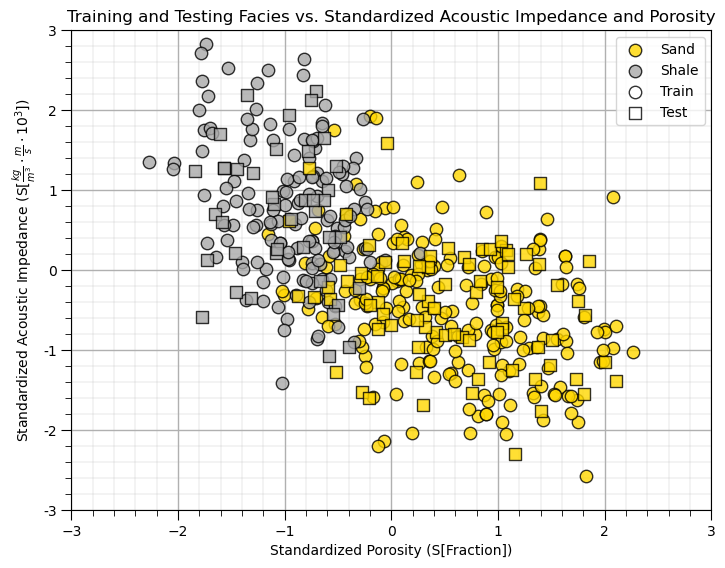

In [21]:
plt.subplot(111)                                              # plot train and test data in predictor feature space
plt.scatter(X_train[Xsname[0]][y_train[yname]==1],X_train[Xsname[1]][y_train[yname]==1],s=80,
            marker='o',color = 'gold',alpha = 0.8,edgecolor = 'black',zorder=1,label='Sand')
plt.scatter(X_train[Xsname[0]][y_train[yname]==0],X_train[Xsname[1]][y_train[yname]==0],s=80,
            marker='o',color = 'darkgrey',alpha = 0.8,edgecolor = 'black',zorder=1,label='Shale')

plt.scatter(X_test[Xsname[0]][y_test[yname]==1],X_test[Xsname[1]][y_test[yname]==1],s=80,
            marker='s',color = 'gold',alpha = 0.8,edgecolor = 'black',zorder=1,)
plt.scatter(X_test[Xsname[0]][y_test[yname]==0],X_test[Xsname[1]][y_test[yname]==0],s=80,
            marker='s',color = 'darkgrey',alpha = 0.8,edgecolor = 'black',zorder=1,)

plt.scatter([-999],[-999],s=80,marker='o',color = 'white',alpha = 0.8,edgecolor = 'black',zorder=1,label='Train')
plt.scatter([-999],[-999],s=80,marker='s',color = 'white',alpha = 0.8,edgecolor = 'black',zorder=1,label='Test')

plt.legend(loc = 'upper right')
plt.title('Training and Testing ' + ylabel + ' vs. ' + Xslabel[1] + ' and ' + Xlabel[0])
plt.xlabel(Xslabelunit[0]); plt.ylabel(Xslabelunit[1]); add_grid(); plt.xlim([Xsmin[0],Xsmax[0]]); plt.ylim([Xsmin[1],Xsmax[1]])
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

This will be a difficult classification,

* there is certainly a lot of overlap
* the boundary may be nonlinear.

But, there is good news,

* the train and test coverage looks good in general, note there are a few testing cases that will test model extrapolation.
* support vector machines are designed to work with this overlap!

#### Support Vector Machine Model with Linear Kernel

Let's start simple, train and visualize linear support vector machine models over our feature space. 

* This will provide a linear spatial classification model for facies 0 and 1 as a function of AI and porosity.

We use the scikit-learn function $SVC$ substantiate the support vector machine:

```python
svm_linear = SVC()
```

The parameters include:

* **kernel** the kernel type that is applied to project the data to a potentially higher dimensional space
* **$C$** penalty for misclassification
* **random_state** random number see for random shuffling data for probability estimates

We then use the command,

```python
svm_linear.fit()
```
to train the model with the training dataset.

The inputs to the fit function include:

* **X** - the $n \times m$ array with the predictor features for the training dataset 
* **y** - the $n \times 1$ array with the response feature for the training dataset 

Let's try out 2 different $C$ penalty hyperparameters to visualize the impact of the penalty for misclassification.

In [24]:
C1_list = [0.01,100]                                          # set hyperparameters
SVM1_list = []

for C in C1_list:                                             # train the models
    SVM1_list.append(SVC(kernel = 'linear',C = C, random_state = seed).fit(X_train[Xsname],y_train)) # instantiate and train

Looks like it ran ok!  Let's visualize the results using the convenient visualization functions that we previously defined. 

In [26]:
for iC, C in enumerate(C1_list):                              # visualize the training data and model
    plt.subplot(1,2,iC+1)
    visualize_SVM(SVM1_list[iC],X_train[Xsname[0]],Xsmin[0],Xsmax[0],X_train[Xsname[1]],Xsmin[1],Xsmax[1],y_train[yname],0.0,1.0,
                Xslabelunit[0],Xslabelunit[1],r'Training Data and Linear Support Vector Machine, $C$ = ' + str(C),[0,1],['Shale','Sand'],
                binary_cmap,True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

The above plot shows the linear kernel support vector machine classification model, the training dataset and the resulting support vectors with bold circles. 

* Linear kernel only provide a straight decision boundary. 
* It is hard to tune the model to fit more complicated situation.

Note that with higher C, weighting of the sum of errors, we get a smaller margin. The linear model is fit with fewer support vectors (training data in the margin. Let's summarize the end members of this hyperparameter with respect to simple and complicated models, potential under and overfit and the model bias and variance trade-off.

* **simple model \ underfit model** - when C is smaller, the classifier is more tolerant with misclassified data points (higher model bias, lower model variance). 
* **complex model \ overfit model** - when C is larger, the classifier is more sensitive to misclassified data points (lower model bias, higher model variance). 

In other words, $C$ is a regularization term, just like the shrinkage term for ridge regression. Let's try some more flexible classifiers with a different kernel so we can better see this.

#### Support Vector Machine Model with Polynomial Kernel

The polynomial kernel is defined as

\begin{equation}
K(x,x') = (x^Tx)^d,
\end{equation}

where $d$ is the degree of polynomials.

The hyperparameter $degree$ is the order of the polynomial kernel function. 

As previously mentioned, let's try out different $C$, penalty for error, with a single polynomial order observe the results.

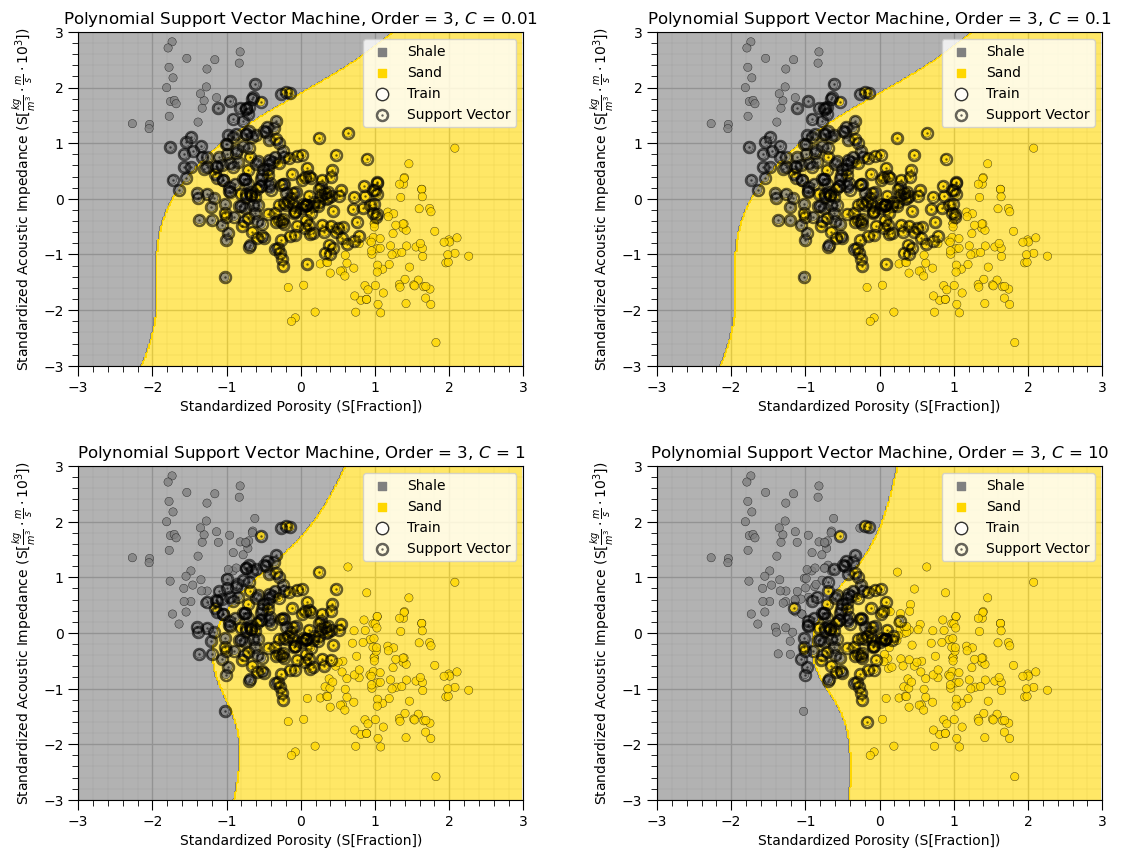

In [28]:
C2_list = [0.01,0.1,1,10]                                     # set hyperparameters
order = np.full((len(C2_list)),3)       
SVM2_list = []

for iC, C in enumerate(C2_list):                              # train the model and visualize the training data and model
    SVM2_list.append(SVC(kernel = 'poly',degree=order[iC],C = C,random_state = seed).fit(X_train[Xsname],y_train)) # instantiate and train
    plt.subplot(2,2,iC+1)
    visualize_SVM(SVM2_list[iC-1],X_train[Xsname[0]],Xsmin[0],Xsmax[0],X_train[Xsname[1]],Xsmin[1],Xsmax[1],y_train[yname],0.0,1.0,
                Xslabelunit[0],Xslabelunit[1],'Polynomial Support Vector Machine, Order = ' + str(order[iC]) + r', $C$ = ' + str(C),
                [0,1],['Shale','Sand'],binary_cmap,True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=1.6, wspace=0.3, hspace=0.3); plt.show()

As we increase the $C$ hyperparameter, the margin shrinks, the number of support vectors reduces and the model complexity increases. 

#### Support Vector Machine Model with Radial Basis Function Kernel

Radial Basis Function (RBF) is another commonly used kernel in SVC:

\begin{equation}
K(x,x') = e^{- \gamma ||x-x'||^2},
\end{equation}

where $||x-x'||^2$ is the squared Euclidean distance between two data points x and x'. 

Gaussian kernel is a special case of RBF, where: 

\begin{equation}
K(x,x') = e^{- \frac {||x-x'||^2} {2 \sigma^2}}.
\end{equation}

By changing the value of $\gamma$ and C, the classifier with an RBF kernel can be tuned.

$\gamma$ can be thought of as the spread of the kernel. 

* when $\gamma$ is low, the curvature of the decision boundary is low, leading to a broad decision region (low variance, high bias), low complexity
* The $\gamma$ parameter can be interpreted as the inverse of the radius of influence of samples selected by the model as support vectors, i.e., low gamma integrates more data for a smoother model 

In [30]:
C3_list = [1e-1, 1, 1e2]                                      # set hyperparameters
gamma1_list = [1e-1, 1, 1e1]

index= 1
for C in C3_list:
    for gamma in gamma1_list:                                 # train the models, visualize the training data and models
        svc = SVC(kernel='rbf',gamma=gamma,C=C,random_state = seed).fit(X_train[Xsname],y_train) # instantiate and train
        plt.subplot(3,3,index)
        visualize_SVM(svc,X_train[Xsname[0]],Xsmin[0],Xsmax[0],X_train[Xsname[1]],Xsmin[1],Xsmax[1],y_train[yname],0.0,1.0,
                Xslabelunit[0],Xslabelunit[1],r'RBF Support Vector Machine, $\gamma$ = ' + str(gamma) + r', $C$ = ' + str(C),
                [0,1],['Shale','Sand'],binary_cmap,True)
        index = index + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.4, top=2.4, wspace=0.3, hspace=0.3); plt.show()

The impact of regularization with the C hyperparameter is very clear in this case,

* higher C, smaller margin, fewer support vectors, tends to overfit
* lower C, larger margin, more support vectors, tends to underfit

The impact of gamma is also very clear in this case,

* higher gamma results in more complicated, high curvature decision boundaries
* lower gamma results in more simple, low curvature, smooth decision boundaries

Although two facies seem to be classified properly in some cases above, there is a risk of overfitting, specifically for the high gamma and high C example.

#### Support Vector Machines without Standardizing the Predictor Features

As promised, let's try a model without standardizing the predictor features.

* this will be illustrative as the original predictor features have very different ranges!

In [32]:
order = 3; C = 0.01                                           # set the hyperparameters
svc_test1 = SVC(kernel='poly',degree=order,C=C,random_state = seed).fit(X_train[Xname],y_train) # fit with original features, not standardized
gamma = 1.0; C = 1.0                                          # set the hyperparameters
svc_test2 = SVC(kernel='rbf',gamma=gamma,C=C,random_state = seed).fit(X_train[Xname],y_train) # fit with original features, not standardized

plt.subplot(121)                                              # visualize the training data and models
visualize_SVM(svc_test1,X_train[Xname[0]],Xmin[0],Xmax[0],X_train[Xname[1]],Xmin[1],Xmax[1],y_train[yname],0.0,1.0,
                Xlabelunit[0],Xlabelunit[1],'Polynomial Support Vector Machine, Order = ' + str(order) + r', $C$ = ' + str(C),
                [0,1],['Shale','Sand'],binary_cmap,True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.subplot(122)
visualize_SVM(svc_test2,X_train[Xname[0]],Xmin[0],Xmax[0],X_train[Xname[1]],Xmin[1],Xmax[1],y_train[yname],0.0,1.0,
                Xlabelunit[0],Xlabelunit[1],r'RBF Support Vector Machine, $\gamma$ = ' + str(gamma) + r', $C$ = ' + str(C),
                [0,1],['Shale','Sand'],binary_cmap,True)
plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=0.8, wspace=0.3, hspace=0.3); plt.show()

What happened?

* The support vector machine with the polynomial kernel splits on the feature with the largest range, acoustic impedance. The differences in the feature with the very small range, porosity here, do not significantly influence to the model.
* The radial basis function support vector machine has thin shale and sand layers over the acoustic impedance.

We must standardize our predictor features to apply support vector machines. 

#### Hyperparameter Tuning

Let's use the brute force grid search with stratified shuffle splits to iterate over multiple hyperparameters and find the optimum model complexity.

* **Grid Search Cross Validation** - models are constructed for the full combinatorial of hyperparameters
* **Stratified Shuffle Splits** - ensures that the balance of categorical cases is preserved in the splits and randomizes the split to ensure the model does use the same data in the same order each time
* warning this will take about 2 minutes to run on a regular PC

In [34]:
C_range = np.logspace(-2, 7, 10)                              # set hyperparameter cases
gamma_range = np.logspace(-6, 3, 10)
param_grid = dict(gamma=gamma_range, C=C_range)               # store hyperparameter cases in a dictionary
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=seed) # instantiate the cross validation method
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv,n_jobs=5).fit(X[Xsname],y) # brute force, full combinatorial search with cross validation 
scores = grid.cv_results_['mean_test_score'].reshape(len(C_range),len(gamma_range)) # retrieve average accuracy and shape as a 2D array for plot

Now we can visualize the cross validation accuracy for all of the hyperparameter combinations.

* note, the output is average accuracy over all of the stratified shuffle splits, where accuracy is,

$$
Accuracy = \frac{n_{\text{correctly classified}}}{n}
$$

In [36]:
plt.subplot(111)                                              # plot results of hyperparameter tuning                               
im = plt.imshow(scores,vmin=0.6,vmax=0.95,cmap=cmap,alpha=1.0)
plt.xlabel(r'$\gamma$ Hyperparameter')
plt.ylabel(r'$C$ Hyperparameter')
cbar = plt.colorbar(im, orientation = 'vertical')
cbar.set_label('Average Classification Accuracy Over Splits', rotation=270, labelpad=20)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.title('SVC Hyperparameter Tuning, Cross Validation Accuracy');

plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.3, hspace=0.3); plt.show()

We can observe a region around $C$ of 100 and $\gamma$ of 0.1 with the best model cross validation accuracy.

#### Visualizing High, Mid and Low Performing Models

Now we show examples of high, mid and low performing model based on validation accuracy from the demonstration above.

* we will use parameter combinations, $C$ and $\gamma$, from the plot above to select and rerun the cases.

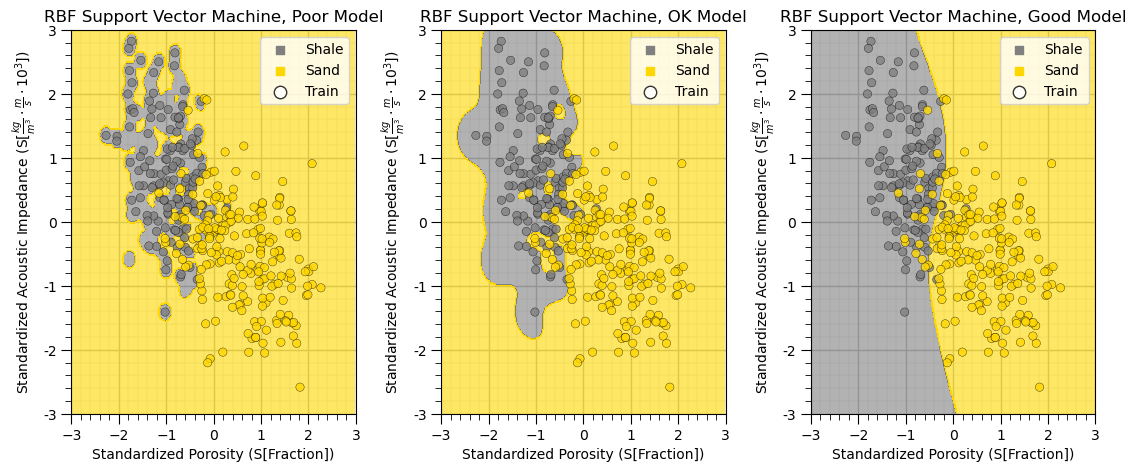

In [38]:
cases = ['Poor','OK','Good']                                  # selected hyperparameter cases for visualization
C_list = [100,100,1e6]
gamma_list = [100,10,0.01]
model_cases = []
 
for icase, case in enumerate(cases):                          # visualize the training data and model
    model_cases.append(SVC(kernel='rbf',C=C_list[icase],gamma=gamma_list[icase]).fit(X[Xsname],y)) # train on all the data
    plt.subplot(1,3,icase+1)                                  # visualize model cases and all data
    visualize_SVM(model_cases[icase],X_train[Xsname[0]],Xsmin[0],Xsmax[0],X_train[Xsname[1]],Xsmin[1],Xsmax[1],y_train[yname],0.0,1.0,
        Xslabelunit[0],Xslabelunit[1],r'RBF Support Vector Machine, ' + str(cases[icase]) + ' Model',[0,1],['Shale','Sand'],binary_cmap,False)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(comma_format))

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=0.8, wspace=0.3, hspace=0.3); plt.show()

By selecting low, mid and high accuracy hyperparameter cases from our hyperparameter tuning cross validation accuracy we obtain a good illustration example of overfit to well-fit models.

#### Comments

I hope you found this tutorial useful. I'm always happy to discuss geostatistics, statistical modeling, uncertainty modeling and machine learning,

*Michael*

#### The Author:

Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig) | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  